In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

In [2]:
import sys
model_path="/home/groups/ZuckermanLab/jalim/egf_m2cO2vae/"
sys.path.append(model_path)
import importlib
import train_loops
import run
from utils import utils
import wandb
import logging
from pathlib import Path
from configs.config_LI204601 import config # Load Pretrained Model Configuration
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print(f'Using Device: {device}')

Using Device: cuda


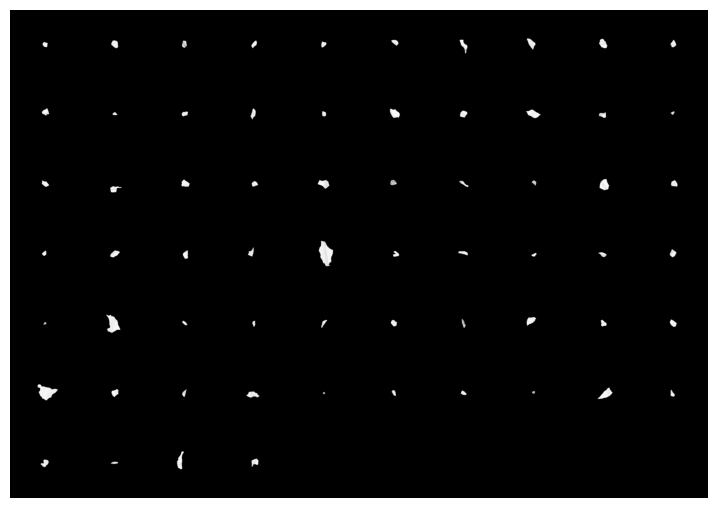

In [4]:
importlib.reload(utils)

dset, loader, dset_test, loader_test = run.get_datasets_from_config(config) # get datasets specified by config
fig, axs = utils.plot_sample_data(loader) # Loading Training Set Images as per the batch size 
fig

In [5]:
config.model.encoder.n_channels = dset[0][0].shape[0]  # image channels
model = run.build_model_from_config(config)

### Get pre-trained model weights

In [6]:
pretrained_model_path = os.path.join(model_path, "wandb/offline-run-20240814_122540-egf_goodFOVs/files/model.pt")

In [7]:
model_checkpoint = torch.load(pretrained_model_path)
model.to(device).cpu().train() # if keys don't match, try many combinations of putting it on and off cuda
#model.to(device).train()
missing_keys, unexpected_keys = model.load_state_dict(model_checkpoint['model_state_dict'], strict=False)
assert all(['_basisexpansion' in k for k in missing_keys]) # checking that the only missing keys from the state_dict are this one type

In [8]:
from utils import eval_utils
importlib.reload(eval_utils)
model.eval().cpu() 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).cpu()
x, y = next(iter(loader)) # One Batch: Training Set
#x, y = next(iter(loader_test)) # One Batch: Test Set

print(f"x shape: {x.shape}, device: {x.device}")
print(f"y shape: {y.shape}, device: {y.device}")

x shape: torch.Size([64, 1, 256, 256]), device: cpu
y shape: torch.Size([64]), device: cpu


### Run on CPU & Visualize the reconstruction grids

In [9]:
try:
    reconstruct_grid_aligned = eval_utils.reconstruction_grid(model, x.cpu(), align=True, device='cpu')
except Exception as e:
    print(f"Error on CPU: {e}")

Combined tensor shape: torch.Size([96, 1, 256, 258])
Grid shape: torch.Size([3098, 2082, 3])


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/o2vae_test/lib/python3.9/site-packages/torch/nn/functional.py:4404: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/o2vae_test/lib/python3.9/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


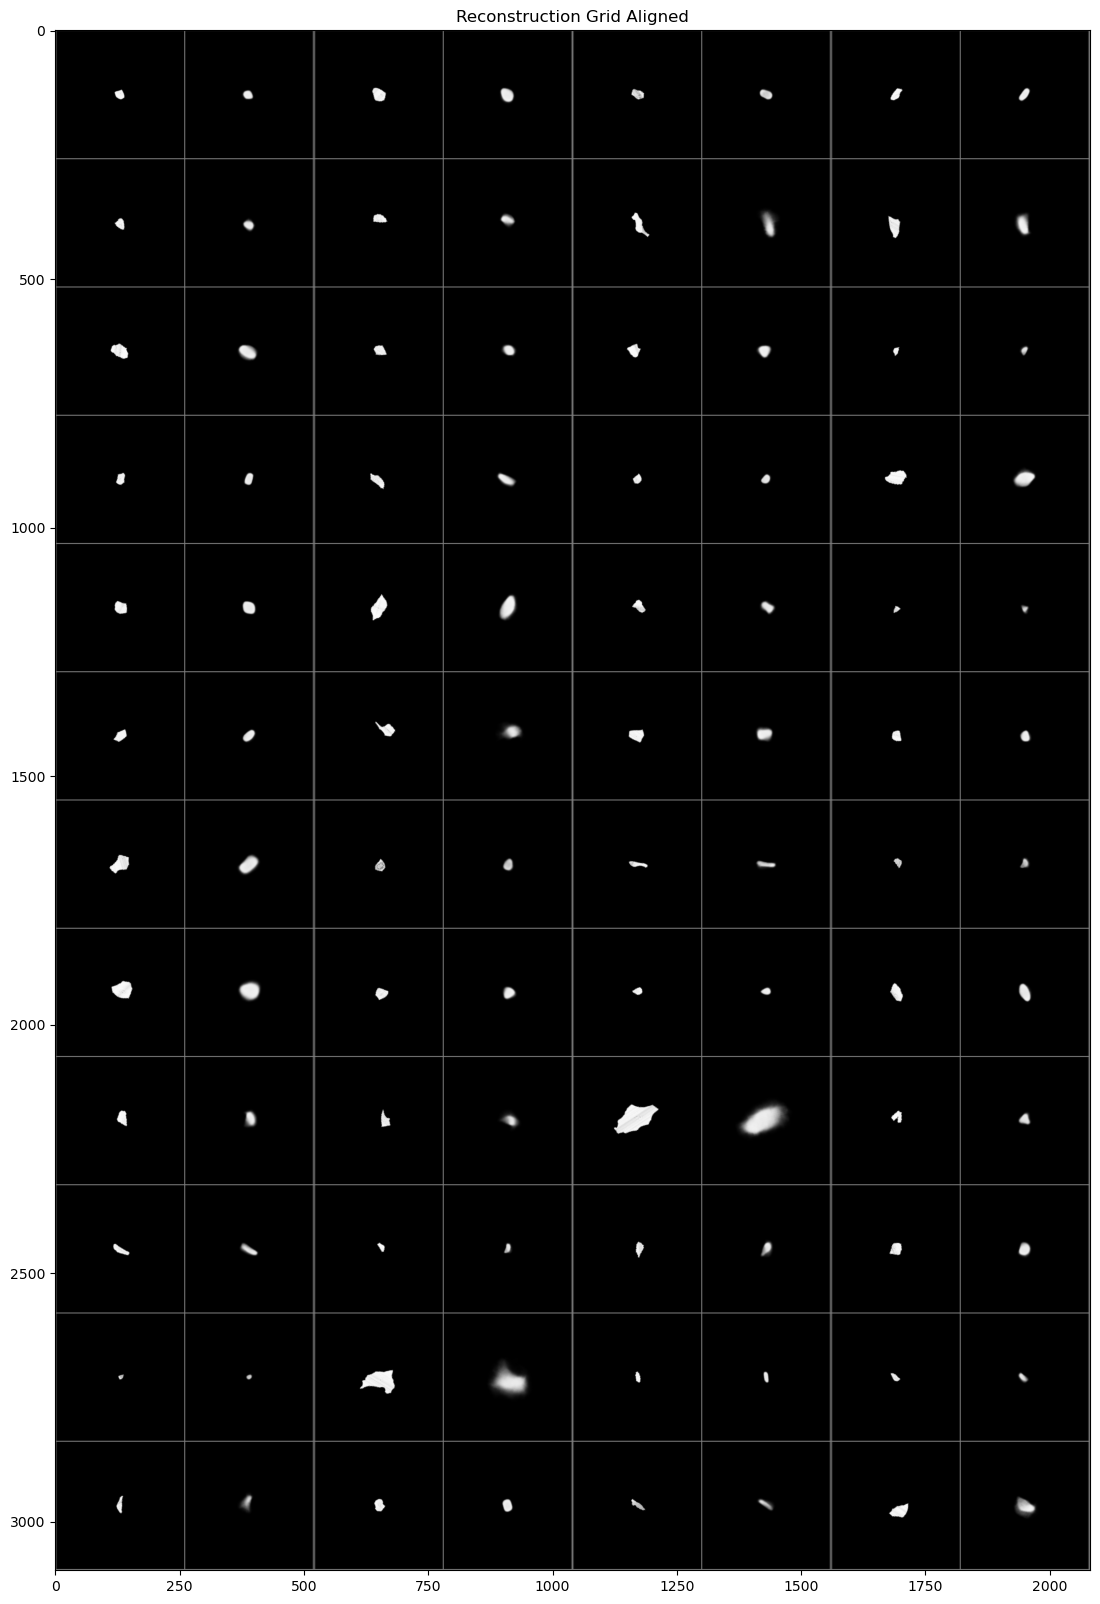

In [13]:
fig, axs = plt.subplots(figsize=(20, 20))
axs.imshow(reconstruct_grid_aligned.numpy(), cmap='gray')
axs.set_title('Reconstruction Grid Aligned')
plt.show()